In [1]:
# import packages
import numpy as np
import scipy.integrate as integrate
from sympy import *
import time

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.animation as animation

from matplotlib import cm
from matplotlib.ticker import LinearLocator
## set default plot size
plt.rcParams["figure.figsize"] = (10, 7)
## set global font size
plt.rcParams.update({'font.size':14})

import astropy.units as u
from astropy import constants as const

# The Gaia phase-space snail

Following Tremaine et al. (2023), I animate the 1D vertical oscillations of stars in a disk, modeled by a self-gravitating isothermal slab.

Eqs. 4-8 describe the dynamics of the slab, and Eq. 1 describes the time evolution of any density perturbation.

# Slab dynamics

Here, I write down Eqs. 4-8 from Tremaine et al. (2023), which includes the dynamics of the slab and the definitions of our angle-action coordinates.

First, I'll simulate just one star at an arbitrary $(\theta,J)$. Eventually, I'll sample ~10,000-100,000 stars from the distribution function Eq. 6.

## Vertical oscillation

Suppose a perturbation at time $t_i$ changes the distribution function $f$ by amplitude $f_0(J)$. Furthermore, for simplicity, only consider the perturbation's m=1 Fourier component in $\theta$. Then this perturbation evolves as:
$$f_0(J) \cos\left[\theta - \Omega(J)(t-t_i)-\theta_i\right] $$

In [2]:
## Omega definitions
def Omega_big(J, Omega_small=1/np.sqrt(2)):
    '''
    See paragraph after Eq. 8 of Tremaine et al. (2023); orbital frequency
    when the action J >> sigma*z_0. Omega_small is the limit of Omega
    when J << sigma*z_0.
    
    '''
    
    coeff = (Omega_small**2 * np.pi)**2
    coeff = (coeff / 3)**(1/3)
    return coeff * J**(-1/3)

def Omega_big_deriv(J, Omega_small=1/np.sqrt(2)):
    '''
    Derivative of the function Omega_big wrt J.
    
    '''
    
    coeff = (Omega_small**2 * np.pi)**2
    coeff = (coeff / 3)**(1/3)
    
    return coeff * (-1/3) * J**(-4/3)

def Omega_interm(J, Omega_small=1/np.sqrt(2)):
    '''
    The "intermediate" expression for Omega: it's an
    interpolation between the low-J and high-J regimes for Omega
    (represented by Omega_small and Omega_big, respectively).
    
    The interpolated function has form a / (1 + b*J)^{1/3}. 
    
    '''
    
    # Omega=Omega_small for J=0
    a = Omega_small
    # coefficient in Omega_big expression
    Omega_big_coeff = Omega_big(1, Omega_small) 
    # for large J, Omega_big ~ Omega_big_coeff * J^{-1/3} ~ a / (b*J)^{1/3},
    # which implies b^(1/3) ~ a/Omega_big_coeff
    b = (a / Omega_big_coeff)**3
    
    num = a
    denom = (1 + b*J)**(1/3)
    return num / denom
    

def Omega(J):
    '''
    Eq. 8 of Tremaine et al. (2023); orbital frequency. Refer to notes on 
    notation and definitions (e.g., definition of Omega_small, setting
    z_0 = 0).
    
    '''
    
    Omega_small = 1 / np.sqrt(2) # norm'd s.t. sigma*z_0=1
    
    return Omega_interm(J, Omega_small) 

def dOmega_dJ(J, Omega_small=1/np.sqrt(2)):
    '''
    Derivative of Omega(J), assuming that Omega(J) = a / (1 + b*J)^{1/3}. . I got
    this expression for the derivative from Wolfram Alpha.
    
    '''
    
    # Omega=Omega_small for J=0
    a = Omega_small 
    # coefficient in Omega_big expression
    Omega_big_coeff = Omega_big(1, Omega_small) 
    # for large J, Omega_big ~ Omega_big_coeff * J^{-1/3} ~ a / (b*J)^{1/3},
    # which implies b^(1/3) ~ a/Omega_big_coeff
    b = (a / Omega_big_coeff)**3
    
    num = -a*b/3
    denom = (1 + b*J)**(4/3)

    return num / denom

In [3]:
def delta_f(theta, J, t, A_0=1, t_i=0, theta_i=0):
    '''
    Eq. 1 of Tremaine et al. (2023). Suppose a perturbation
    at time t_i changes the distribution function f
    by amplitude A_0. For simplicity, only consider the 
    m=1 Fourier component in theta. Then, as a function of time,
    this perturbation evolves as:
    
    delta_f(theta,J,t) = A_0 * cos[theta - Omega(J)(t-t_i) - theta_i]
    
    '''
        
    phase = theta - Omega(J)*(t-t_i) - theta_i
    
    return A_0 * np.cos(phase)

## 2D animation

Adapting my code from my "Phase Mixing Plots" notebook.

Sources for using FuncAnimation instead of ArtistAnimation:

https://matplotlib.org/stable/api/_as_gen/matplotlib.animation.FuncAnimation.html

https://stackoverflow.com/questions/18274137/how-to-animate-text-in-matplotlib

## sanity check: plot $\delta f$ as $\Omega$ vs. $\theta$

In [6]:
def delta_f_Omega_explicit(theta, Omega, t, A_0=1, t_i=0, theta_i=0):
    '''
    Same as delta_f, but we explicitly define Omega instead of 
    calculating it via J.
    
    delta_f(theta,J,t) = A_0 * cos[theta - Omega(J)(t-t_i) - theta_i]
    
    '''
        
    phase = theta - Omega*(t-t_i) - theta_i
    
    return A_0 * np.cos(phase)

In [9]:
# time range
tmin = 0
tmax = 10 # in Fig. 3, the time T-t_i goes to 100
tstep = 0.5
ts = np.arange(tmin, tmax, tstep)

# phase space (angle vs. action) grid
theta_min = 0
theta_max = 2*np.pi
Omega_min = 0.
Omega_max = 0.7
step = 2e-2

thetas = np.arange(theta_min, theta_max, theta_max/50)
Omegas = np.arange(Omega_min, Omega_max, step)
thetas, Omegas = np.meshgrid(thetas, Omegas)

In [ ]:
## plot delta_f in Omega vs. theta space
fig, ax = plt.subplots(1,1,figsize=(10,10))

# initialize the color bar
Z = delta_f_Omega_explicit(thetas, Omegas, t=0)
im = ax.imshow(Z, cmap=cm.coolwarm, origin='lower', \
       extent=(theta_min, theta_max, Omega_min, Omega_max), animated=True, \
       aspect='auto') # automatically set plot's aspect ratio
fig.colorbar(im)

ax.set_xlabel(r'$\theta$')
ax.set_ylabel(r'$\Omega$')

# the overdensity at theta=0 as a function of time; ie, delta_n(theta=0, t)
delta_n_array = []

def init():
    im.set_data([])
    return im

def updatefig(num):

    t = ts[num]
    Z = delta_f_Omega_explicit(thetas, Omegas, t)
    
    delta_n = np.sum(Z[:, 0]) # integrate over J
    delta_n_array.append(delta_n)
    
    ## plot delta_f in Omega vs. theta phase space
    Z = Z[:-1, :-1]
    im.set_data(Z)
    
    ax.set_title('Gaia phase mixing (t=' + str(t) + ')')
    
    return im,


ani = animation.FuncAnimation(fig, updatefig, frames=len(ts), interval=100, blit=True)

ani.save("Gaia_phase_mixing_func_temp.mp4")

## plot $\delta f$ in angle-action coords

In [11]:
## set bounds for t, theta, and J

# time range
tmin = 0
tmax = 100 # in Fig. 3, the time T-t_i goes to 100
tstep = 0.5
ts = np.arange(tmin, tmax, tstep)

# phase space (angle vs. action) grid
theta_min = 0
theta_max = 2*np.pi
theta_step = theta_max/100

J_min = 1e-5
# in Scott's paper, the max. value of (v/sigma)*(z/z_0) ~ 20 in Fig. 3, and 
# we norm'd s.t. sigma*z_0=1. from eq. 7, J is roughly prop to v*z 
J_max = 10 
step = 1e-2

thetas = np.arange(theta_min, theta_max, theta_step)
Js = np.arange(J_min, J_max, step)
thetas, Js = np.meshgrid(thetas, Js)

# test that delta_f can take in a meshgrid
Z = delta_f(thetas, Js, 0.)

### define sqrt scale
Source: https://stackoverflow.com/questions/42277989/square-root-scale-using-matplotlib-python

In [12]:
## define square root scale for y axis
import matplotlib.scale as mscale
import matplotlib.transforms as mtransforms
import matplotlib.ticker as ticker

class SquareRootScale(mscale.ScaleBase):
    """
    ScaleBase class for generating square root scale.
    """
 
    name = 'squareroot'
 
    def __init__(self, axis, **kwargs):
        # note in older versions of matplotlib (<3.1), this worked fine.
        # mscale.ScaleBase.__init__(self)

        # In newer versions (>=3.1), you also need to pass in `axis` as an arg
        mscale.ScaleBase.__init__(self, axis)
 
    def set_default_locators_and_formatters(self, axis):
        axis.set_major_locator(ticker.AutoLocator())
        axis.set_major_formatter(ticker.ScalarFormatter())
        axis.set_minor_locator(ticker.NullLocator())
        axis.set_minor_formatter(ticker.NullFormatter())
 
    def limit_range_for_scale(self, vmin, vmax, minpos):
        return  max(0., vmin), vmax
 
    class SquareRootTransform(mtransforms.Transform):
        input_dims = 1
        output_dims = 1
        is_separable = True
 
        def transform_non_affine(self, a): 
            return np.array(a)**0.5
 
        def inverted(self):
            return SquareRootScale.InvertedSquareRootTransform()
 
    class InvertedSquareRootTransform(mtransforms.Transform):
        input_dims = 1
        output_dims = 1
        is_separable = True
 
        def transform(self, a):
            return np.array(a)**2
 
        def inverted(self):
            return SquareRootScale.SquareRootTransform()
 
    def get_transform(self):
        return self.SquareRootTransform()
 
mscale.register_scale(SquareRootScale)

t = 0.0
Elapsed t: 0.2 seconds
t = 0.0
Elapsed t: 0.2 seconds
t = 0.0
Elapsed t: 0.2 seconds
t = 5.0
Elapsed t: 2.5 seconds
t = 10.0
Elapsed t: 4.7 seconds
t = 15.0
Elapsed t: 6.9 seconds
t = 20.0
Elapsed t: 9.2 seconds
t = 25.0
Elapsed t: 11.3 seconds
t = 30.0
Elapsed t: 13.5 seconds
t = 35.0
Elapsed t: 15.7 seconds
t = 40.0
Elapsed t: 17.9 seconds
t = 45.0
Elapsed t: 20.1 seconds
t = 50.0
Elapsed t: 22.4 seconds
t = 55.0
Elapsed t: 24.6 seconds
t = 60.0
Elapsed t: 26.7 seconds
t = 65.0
Elapsed t: 28.9 seconds
t = 70.0
Elapsed t: 31.1 seconds
t = 75.0
Elapsed t: 33.2 seconds
t = 80.0
Elapsed t: 35.4 seconds
t = 85.0
Elapsed t: 37.5 seconds
t = 90.0
Elapsed t: 39.7 seconds
t = 95.0
Elapsed t: 41.8 seconds


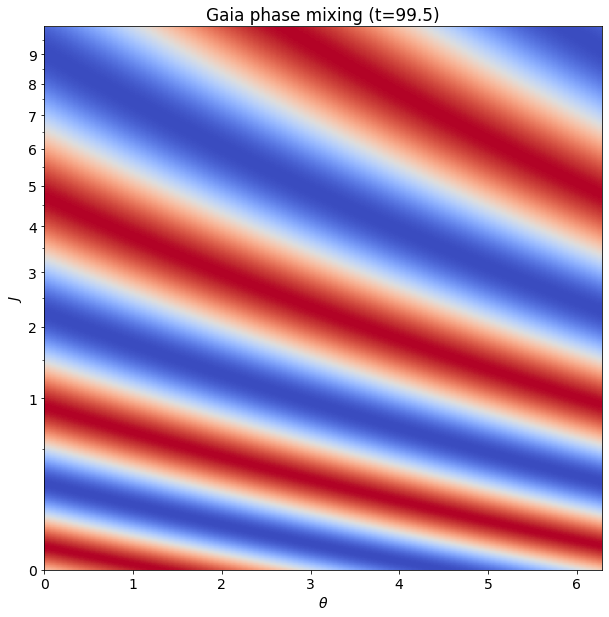

In [13]:
## phase mixing animation (J vs theta)
fig, ax = plt.subplots(1,1,figsize=(10,10))

# initialize the color bar
Z = delta_f(thetas, Js, 0)
im = ax.imshow(Z, cmap=cm.coolwarm, origin='lower', \
                   extent=(theta_min, theta_max, J_min, J_max), animated=True, \
                   aspect='auto') # automatically set plot's aspect ratiofig.colorbar(im)

ax.set_xlabel(r"$\theta$")
ax.set_ylabel(r"$J$")
## scale the J axis to be linear in sqrt(J)
ax.set_yscale('squareroot')
ax.set_yticks(np.arange(J_min, J_max, 1))
ax.set_yticks(np.arange(J_min, J_max, 0.5), minor=True)

# the overdensity at theta=0 as a function of time; ie, delta_n(theta=0, t)
delta_n_array = []

def init():
    im.set_data([])
    return im

start = time.time()
def updatefig(num):

    t = ts[num]
    if ((t % 5) == 0):
        print("t = " + str(t))
        print(f'Elapsed t: {np.round(time.time() - start, 1)} seconds')
        
    Z = delta_f(thetas, Js, t)
    delta_n = np.sum(Z[:, 0]) # integrate over J
    delta_n_array.append(delta_n)
    
    ## plot delta_f in J vs. theta phase space
    Z = Z[:-1, :-1]
    im.set_data(Z)
    
    ax.set_title('Gaia phase mixing (t=' + str(t) + ')')
    
    return im,


ani = animation.FuncAnimation(fig, updatefig, frames=len(ts), interval=100, blit=True)

ani.save("Gaia_phase_mixing_func_temp.mp4")

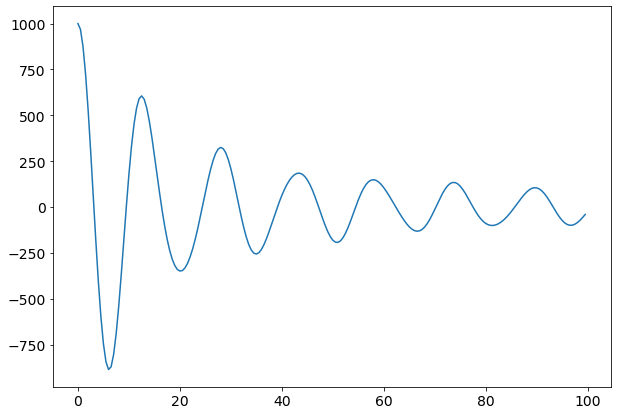

In [14]:
# density at theta=0
plt.plot(ts, delta_n_array[2:])

## Plotting $\delta f$ in polar coordinates

For now, I'll assume that vertical position $z$ corresponds to $\sqrt{J} \cos\theta$ and vertical velocity $v_z$ corresponds to $\sqrt{J} \sin\theta$. This isn't completely accurate because this assumes harmonic oscillations, while our system has an anharmonic oscillations. However, I'm making this assumption just so that I set up the code for integrating over $v_z$.

Python conversion between coordinates: https://stackoverflow.com/questions/20924085/python-conversion-between-coordinates

Imshow in polar coordinates: https://stackoverflow.com/questions/54209640/imshow-in-polar-coordinates

Using set_array to (properly) update the data in the figure at each timestep: https://stackoverflow.com/questions/18797175/animation-with-pcolormesh-routine-in-matplotlib-how-do-i-initialize-the-data

And a very detailed animation example: http://jakevdp.github.io/blog/2012/08/18/matplotlib-animation-tutorial/

In [4]:
## convert our (thetas, Js) to (x_vals, y_vals)

def pol2cart_meshgrid(thetas, Js):
    '''
    Given a meshgrid of angles and actions (thetas, Js), return the 
    corresponding meshgrid in Cartesian coordinates.
    
    '''
    
    xs = np.sqrt(Js) * np.cos(thetas)
    ys = np.sqrt(Js) * np.sin(thetas)
    
    return xs, ys

# thetas, Js are generated from a meshgrid 
x_vals, y_vals = pol2cart_meshgrid(thetas, Js)

NameError: name 'thetas' is not defined

<ipython-input-16-9e9e169d5d25>:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  quad1 = ax.pcolormesh(x_vals,y_vals,Z, cmap=cm.coolwarm, animated=True)


t = 0.0
Elapsed t: 0.2 seconds
t = 0.0
Elapsed t: 0.3 seconds
t = 0.0
Elapsed t: 0.3 seconds
t = 5.0
Elapsed t: 4.7 seconds
t = 10.0
Elapsed t: 9.2 seconds
t = 15.0
Elapsed t: 15.1 seconds
t = 20.0
Elapsed t: 20.3 seconds
t = 25.0
Elapsed t: 24.5 seconds
t = 30.0
Elapsed t: 28.8 seconds
t = 35.0
Elapsed t: 33.1 seconds
t = 40.0
Elapsed t: 37.4 seconds
t = 45.0
Elapsed t: 41.6 seconds
t = 50.0
Elapsed t: 46.0 seconds
t = 55.0
Elapsed t: 50.3 seconds
t = 60.0
Elapsed t: 54.4 seconds
t = 65.0
Elapsed t: 58.6 seconds
t = 70.0
Elapsed t: 63.1 seconds
t = 75.0
Elapsed t: 67.3 seconds
t = 80.0
Elapsed t: 71.5 seconds
t = 85.0
Elapsed t: 76.1 seconds
t = 90.0
Elapsed t: 80.5 seconds
t = 95.0
Elapsed t: 84.6 seconds


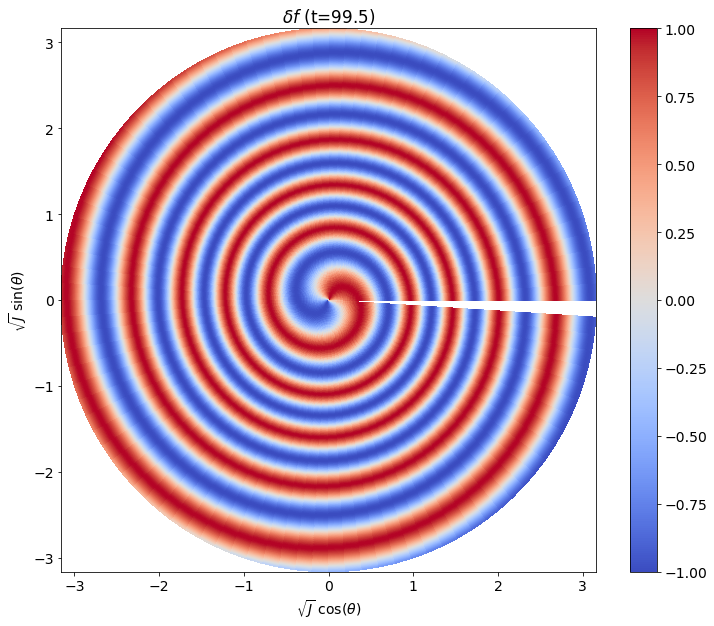

In [16]:
fig, ax = plt.subplots(1,1,figsize=(12,10))

Z = delta_f(thetas, Js, 0)
# quad mesh
quad1 = ax.pcolormesh(x_vals,y_vals,Z, cmap=cm.coolwarm, animated=True)
fig.colorbar(quad1, ax=ax)

ax.set_xlabel(r"$\sqrt{J}$ cos($\theta$)")
ax.set_ylabel(r"$\sqrt{J}$ sin($\theta$)")

def init():
    quad1.set_array([])
    return quad1

start = time.time()

def updatefig(num):
    # global im
    t = ts[num]
    if ((t % 5) == 0):
        print("t = " + str(t))
        print(f'Elapsed t: {np.round(time.time() - start, 1)} seconds')

    Z = delta_f(thetas, Js, t)
    Z = Z[:-1, :-1]
    quad1.set_array(Z.ravel())
    
    ax.set_title('$\delta f$ (t=' + str(t) + ')')
    
    return quad1,


ani = animation.FuncAnimation(fig, updatefig, interval=100, frames=len(ts), blit=True)

ani.save("Gaia_pm_polar_temp.mp4")

In [ ]:
## plotting the Gaia phase mixing snail at 1 timepoint
# plt.clf()
# fig, ax = plt.subplots(1,1,figsize=(12,10))

# # test that we can plot delta_f at a given t
# Z = delta_f(thetas, Js, 25.5)

# im = ax.pcolormesh(x_vals,y_vals,Z,cmap=cm.coolwarm, animated=True)

# fig.colorbar(im, ax=ax)

# ax.set_xlabel(r"$\sqrt{J}$ cos($\theta$)")
# ax.set_ylabel(r"$\sqrt{J}$ sin($\theta$)")
# ax.set_title("$\delta f$")

# plt.show()

# Plotting the echo term

In [5]:
## definitions for Hamiltonian and f0 (and its derivatives)
def Hamiltonian(J, Omega_small=1/np.sqrt(2)):
    '''
    Computes the Hamiltonian of our system by integrating Omega(J)
    from 0 to J. (Underneath Eq. 8 in Scott's paper, it's stated that
    Omega = dH/dJ.) We assume that Omega=0 for H=0.
    
    Also, we use Omega = a/(1 + b*J^{1/3}). I got the form of the 
    integral from Wolfram Alpha.
    
    
    '''
    
    # Omega=Omega_small for J=0
    a = Omega_small 
    # coefficient in Omega_big expression
    Omega_big_coeff = Omega_big(1, Omega_small) 
    # for large J, Omega_big ~ Omega_big_coeff * J^{-1/3} ~ a/b * J^{-1/3}
    b = a / Omega_big_coeff
    
    expr1 = b*J**(1/3) * (b*J**(1/3) - 2)
    expr2 = 2*np.log(b*J**(1/3) + 1)
    numerator = 3*a*(expr1 + expr2)
    denominator = 2 * b**3
    
    return numerator/denominator

def f_0(J): 
    '''
    Initial distribution function of our system, using Eq. 6 of Scott's
    paper (ignoring the constant coefficient).
    
    '''
    
    return np.exp(-1*Hamiltonian(J))

def df0_dJ(J):
    '''
    The derivative of our initial distribution function, f_0(J) ~ exp(-H(J)). 
    We have df_0/dJ = -dH/dJ * exp(-H) = -Omega(J) * exp(-H).
    
    '''
    
    return -Omega(J) * np.exp(-1*Hamiltonian(J))

def f0_second_deriv(J):
    '''
    The second derivative of our initial distribution function, f_0(J) ~ exp(-H(J)). 
    By product rule, taking the derivative of df_0/dJ yields:
    
    -dOmega/dJ * exp(-H) + -Omega * [-dH/dJ * exp(-H)] = -dOmega/dJ * exp(-H) + (Omega^2)*exp(-H)
    = (-dOmega/dJ + Omega^2) * exp(-H)
    
    '''
        
    coeff = Omega(J)**2 - dOmega_dJ(J)
    
    return coeff * np.exp(-1*Hamiltonian(J))

In [6]:
def delta_f_2nd_order(theta, J, t, t2=15):
    '''
    Represents the closed form of the second-order solution for delta_f 
    given two hammers. See the last equations in Section 7.3 in my senior thesis 
    notes.
    
    
    '''
    
    n1, n2 = 1, 2
    t1 = 5
    t_echo = (n2*t2 - n1*t1) / (n2 - n1)
    
    # amplitudes of hammers; for now, assume they're independent of J
    # could use SymPy or something similar to evaluate the d/dJ derivatives
    A1, A2 = 0.1, 0.2
    
    # function that contains the time evolution
    psi = (n2 - n1) * (theta - Omega(J)*(t - t_echo))
    
    # form of delta_f^(2) that assumes constant A_1, A_2
    
    expr1 = 2*A1*A2 * np.cos(psi) * n1*n2* f0_second_deriv(J)
    expr2 = 2*A1*A2 * np.sin(psi) * n1**2 * n2 * (t2-t1) * dOmega_dJ(J) * df0_dJ(J)
    
    return expr1 - expr2

In [17]:
# time range
tmin = 15 # echo term is only nonzero for t>t2
tmax = 55 # in Matt's animation, t goes to 35
tstep = .5
ts = np.arange(tmin, tmax+tstep, tstep)

# phase space (angle vs. action) grid
theta_min = 0
theta_max = 2*np.pi
theta_step = theta_max/70

J_min = 0
# in Scott's paper, the max. value of (v/sigma)*(z/z_0) ~ 20 in Fig. 3, and 
# we norm'd s.t. sigma*z_0=1. from eq. 7, J is roughly prop to v*z 
J_max = 20
J_step = 0.1

thetas = np.arange(theta_min, theta_max, theta_step)
Js = np.arange(J_min, J_max, J_step)
thetas, Js = np.meshgrid(thetas, Js)

# thetas, Js are generated from a meshgrid 
x_vals, y_vals = pol2cart_meshgrid(thetas, Js)

Symmetric log for the color bar: https://matplotlib.org/stable/users/explain/colors/colormapnorms.html#symmetric-logarithmic

In [ ]:
## one snapshot of echo 
Z = delta_f_2nd_order(thetas, Js, 55, t2=15)

fig, ax = plt.subplots(1, 1)

im = ax.pcolormesh(thetas, Js, Z, norm=colors.SymLogNorm(linthresh=1e-6, linscale=1e-6,\
                               base=10),\
                       cmap=cm.coolwarm, shading='auto')
fig.colorbar(im, ax=ax, extend='both')

plt.show()

In [ ]:
## echo term in J/theta coords

fig, ax = plt.subplots(1,1,figsize=(12,10))

# initialize the color bar
Z = delta_f_2nd_order(thetas, Js, 15, t2=15)
quad1 = ax.pcolormesh(thetas, Js, Z, norm=colors.SymLogNorm(linthresh=1e-6, linscale=1e-6,\
                        base=10),\
                       cmap=cm.coolwarm, shading='auto')
fig.colorbar(quad1, ax=ax, extend='both')

ax.set_xlabel(r"$\theta$")
ax.set_ylabel(r"$J$")

# the overdensity at theta=0 as a function of time; ie, delta_n(theta=0, t)
delta_n_array = []

def init():
    quad1.set_array([])
    return quad1

start = time.time()
def updatefig(num):
    
    t = ts[num]
    if ((t % 2) == 0):
        print("t = " + str(t))
        print(f'Elapsed t: {np.round(time.time() - start, 1)} seconds')
        
    Z = delta_f_2nd_order(thetas, Js, t)
    
    delta_n = np.sum(Z[:, 0]) # integrate over J
    delta_n_array.append(delta_n)
    
    ## plot delta_f in J vs. theta phase space
    #Z = Z[:-1, :-1]
    quad1.set_array(Z.ravel())
    
    ax.set_title('Galactic echo (t=' + str(t) + ')')

    return im,


ani = animation.FuncAnimation(fig, updatefig, frames=len(ts), interval=100, blit=True)

ani.save("gal_echo_temp.mp4")

In [ ]:
# density at theta=0
plt.plot(ts, delta_n_array[2:])

## echo term in polar coords

<ipython-input-18-f80f7f07051b>:5: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  quad1 = ax.pcolormesh(x_vals,y_vals,Z, norm=colors.SymLogNorm(linthresh=1e-6, linscale=1e-6,\


t = 15.0
Elapsed t: 0.3 seconds
t = 15.0
Elapsed t: 0.4 seconds
t = 15.0
Elapsed t: 0.4 seconds
t = 20.0
Elapsed t: 2.5 seconds
t = 25.0
Elapsed t: 4.7 seconds
t = 30.0
Elapsed t: 7.1 seconds
t = 35.0
Elapsed t: 9.4 seconds
t = 40.0
Elapsed t: 11.4 seconds
t = 45.0
Elapsed t: 13.5 seconds
t = 50.0
Elapsed t: 16.2 seconds
t = 55.0
Elapsed t: 19.2 seconds


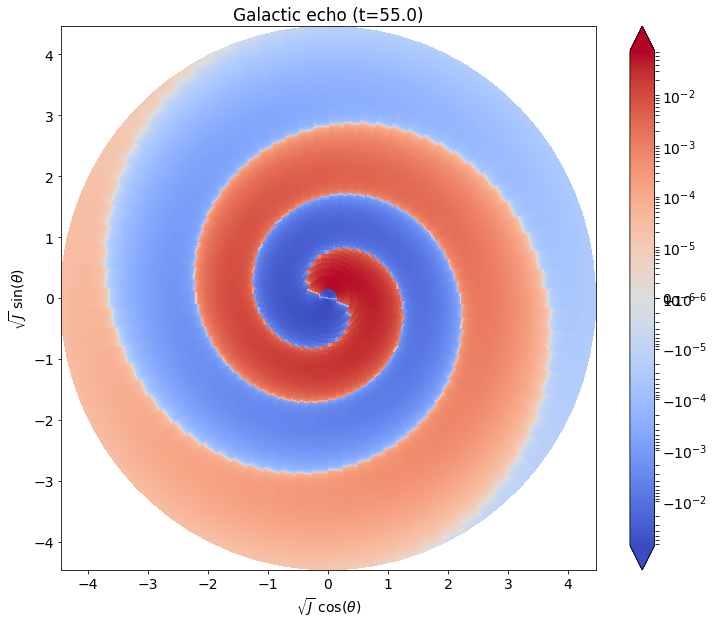

In [18]:
fig, ax = plt.subplots(1,1,figsize=(12,10))

Z = delta_f_2nd_order(thetas, Js, 15, t2=15)
# quad mesh
quad1 = ax.pcolormesh(x_vals,y_vals,Z, norm=colors.SymLogNorm(linthresh=1e-6, linscale=1e-6,\
                        base=10),\
                       cmap=cm.coolwarm, shading='auto')
fig.colorbar(quad1, ax=ax, extend='both')

ax.set_xlabel(r"$\sqrt{J}$ cos($\theta$)")
ax.set_ylabel(r"$\sqrt{J}$ sin($\theta$)")

def init():
    quad1.set_array([])
    return quad1

start = time.time()

def updatefig(num):
    t = ts[num]
    if ((t % 5) == 0):
        print("t = " + str(t))
        print(f'Elapsed t: {np.round(time.time() - start, 1)} seconds')

     
    Z = delta_f_2nd_order(thetas, Js, t)  
    quad1.set_array(Z.ravel())
    
    ax.set_title('Galactic echo (t=' + str(t) + ')')
    
    return quad1,


ani = animation.FuncAnimation(fig, updatefig, interval=100, frames=len(ts), blit=True)

ani.save("gal_echo_polar_temp.mp4")